# Segmenting and Clustering Neighborhoods in Toronto

### Third part: Clustering (K-means)

##### Note
GitHub cannot display folium maps with dynamic visualization.

In [27]:
# Web scraping and geographical coordinates (part one and two)

# !conda install -c conda-forge lxml
# !conda install -c conda-forge bs4

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re

website_url = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(website_url,'html.parser')
My_table = soup.find('table',{'class':'wikitable sortable'})

# Columns from the Wikipedia table
col_name = My_table.findAll("th")
columnas = []
for x in col_name:
    columnas.append(x.get_text())
columnas = [x.strip() for x in columnas if str(x)]

# Data from table
data = My_table.findAll("td")

info = []
for x in data:
    info.append(x.get_text())
info = [x.strip() for x in info if str(x)]

postal_code = [info[x] for x in range(0,len(info),3)]
borough = [info[x+1] for x in range(0,len(info)-1,3)]
neighborhood = [info[x+2] for x in range(0,len(info)-2,3)]

# Dataframe 
temp_df = pd.DataFrame([postal_code, borough, neighborhood]).T
temp_df.columns = ["PostalCode","Borough", "Neighborhood"]

temp_df = temp_df[temp_df["Borough"] != "Not assigned"]
temp_df.reset_index(inplace = True, drop = True)

temp_df['Borough'] = temp_df['Borough'].replace('\s+', ' ', regex = True)
for x in range(len(temp_df.index)):
    if temp_df["Neighborhood"][x] == "":
        temp_df["Neighborhood"][x] = temp_df["Borough"][x]
    else:
        pass

temp_df['Neighborhood'] = temp_df['Neighborhood'].replace('\s+', ' ', regex = True)
temp_df['Neighborhood'] = temp_df['Neighborhood'].str.replace(' /',',')

# temp_df.head()
# temp_df.shape

coordinate = pd.read_csv("https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv")

temp_df = temp_df.merge(
    coordinate, 
    how = "inner", 
    left_on = "PostalCode", 
    right_on = "Postal Code",
    suffixes=('_master', '_using')
    )

df = temp_df.drop(labels = 'Postal Code', axis = 1)

# df.head()

## K-means clustering

In [28]:
# !conda install -c conda-forge geopy
# !conda install -c conda-forge folium

import json
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

### Keep neighborhoods from Toronto.

In [48]:
# Toronto neighborhoods

df_toronto = df
df_toronto = df_toronto[df_toronto["Borough"].str.contains("Toronto")]
df_toronto.reset_index(drop = True, inplace = True)
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


### Toronto map

In [49]:
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_toronto = folium.Map(location = [latitude, longitude], zoom_start = 12)

for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_toronto)  

In [50]:
# The code was removed by Watson Studio for sharing.

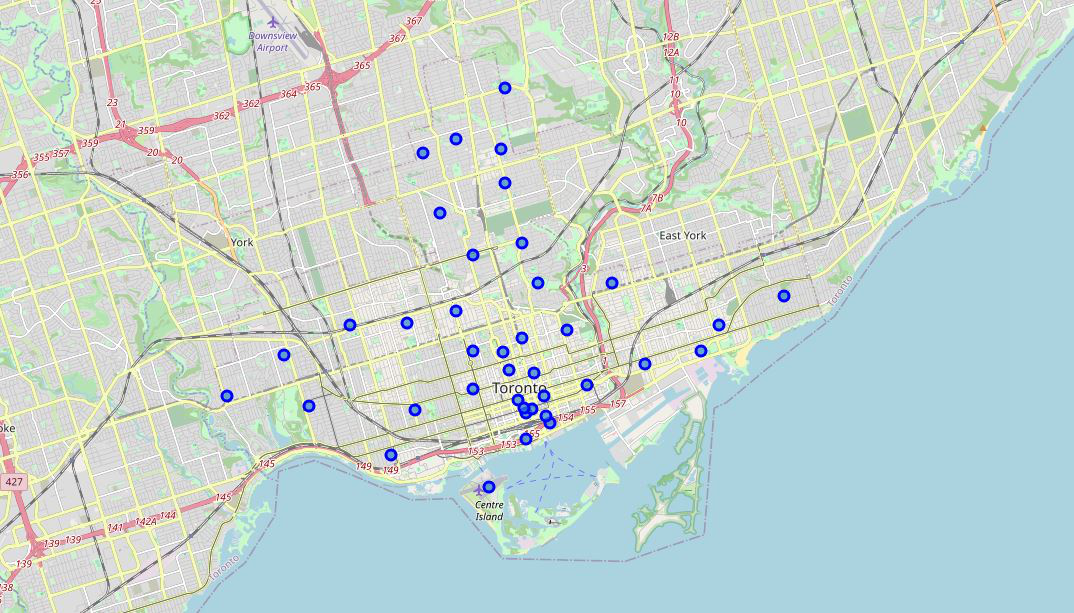

In [51]:
from PIL import Image
img = Image.open(streaming_body_3)
img

### Using Foursquare to get information from our neighborhoods.

In [52]:
# The code was removed by Watson Studio for sharing.

In [53]:
# Foursquare

LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


toronto_venues = getNearbyVenues(
    names=df_toronto['Neighborhood'],
    latitudes=df_toronto['Latitude'],
    longitudes=df_toronto['Longitude']
    )

In [54]:
# Unique categories
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 232 uniques categories.


### Getting most common venues by neighborhoods.

In [55]:
# One-Hot enconding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()
toronto_onehot.shape

toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.shape

(39, 233)

### Sorting the venues in descending order

In [56]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Café,Beer Bar,Bakery,Restaurant,Seafood Restaurant,Cosmetics Shop,Fish Market
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Gym,Bakery,Performing Arts Venue,Pet Store,Nightclub,Climbing Gym,Restaurant
2,Business reply mail Processing Centre,Pizza Place,Auto Workshop,Comic Shop,Restaurant,Burrito Place,Brewery,Skate Park,Smoke Shop,Park,Spa
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport,Boutique,Rental Car Location,Coffee Shop,Plane,Harbor / Marina,Boat or Ferry,Sculpture Garden
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Ice Cream Shop,Thai Restaurant,Salad Place,Bar,Burger Joint,Bubble Tea Shop


### K-means

In [57]:
# Clustering 
kclusters = 5
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_[0:10] 

# Clusters and top 10 venues for each neighborhood.
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

### Cluster visualization

In [59]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

In [60]:
# The code was removed by Watson Studio for sharing.

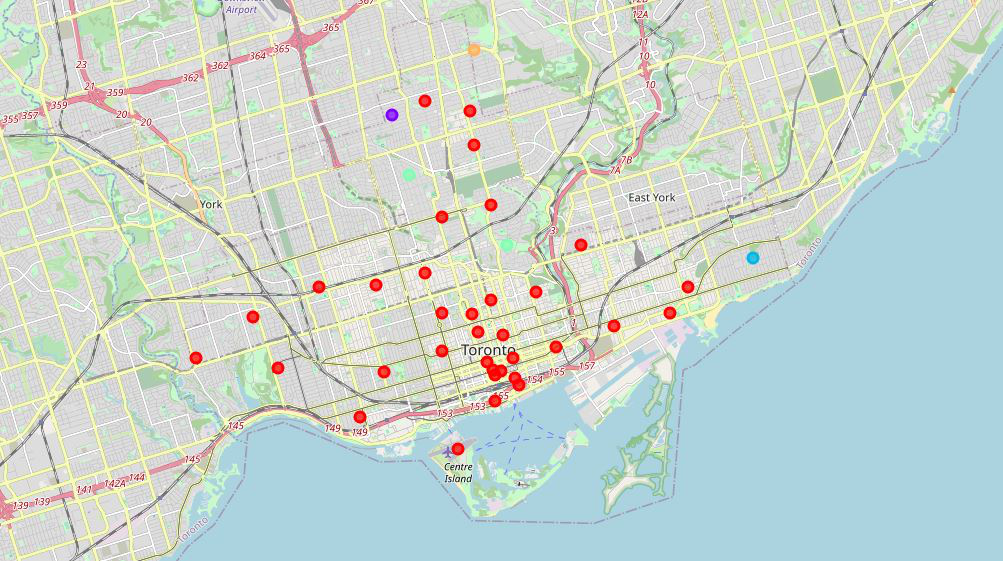

In [61]:
from PIL import Image
img2 = Image.open(streaming_body_5)
img2  

### Clusters

#### Cluster 1

In [62]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,Mexican Restaurant,Shoe Store,Restaurant
1,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Diner,Discount Store,Mexican Restaurant,Juice Bar,Japanese Restaurant,Italian Restaurant,Hobby Shop,Fried Chicken Joint
2,Downtown Toronto,0,Clothing Store,Coffee Shop,Café,Italian Restaurant,Middle Eastern Restaurant,Restaurant,Japanese Restaurant,Cosmetics Shop,Bubble Tea Shop,Diner
3,Downtown Toronto,0,Coffee Shop,Café,Gastropub,American Restaurant,Cocktail Bar,Seafood Restaurant,Hotel,Italian Restaurant,Lingerie Store,Department Store
5,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Cheese Shop,Café,Beer Bar,Bakery,Restaurant,Seafood Restaurant,Cosmetics Shop,Fish Market
6,Downtown Toronto,0,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Ice Cream Shop,Thai Restaurant,Salad Place,Bar,Burger Joint,Bubble Tea Shop
7,Downtown Toronto,0,Grocery Store,Café,Park,Italian Restaurant,Restaurant,Baby Store,Diner,Athletics & Sports,Coffee Shop,Candy Store
8,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Gym,Clothing Store,Hotel,Thai Restaurant,Deli / Bodega,Sushi Restaurant,Bookstore
9,West Toronto,0,Pharmacy,Bakery,Music Venue,Liquor Store,Café,Middle Eastern Restaurant,Recording Studio,Bar,Supermarket,Bank
10,Downtown Toronto,0,Coffee Shop,Aquarium,Café,Hotel,Italian Restaurant,Brewery,Fried Chicken Joint,Restaurant,Scenic Lookout,Sporting Goods Shop


#### Cluster 2

In [63]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,1,Garden,Yoga Studio,Department Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant


#### Cluster 3

In [64]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,East Toronto,2,Neighborhood,Trail,Pub,Health Food Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant


#### Cluster 4

In [65]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Central Toronto,3,Park,Jewelry Store,Trail,Sushi Restaurant,Yoga Studio,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
33,Downtown Toronto,3,Park,Playground,Trail,Yoga Studio,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop


#### Cluster 5

In [66]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,4,Park,Swim School,Bus Line,Yoga Studio,Diner,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
